In [ ]:
from pypower.api import loadcase, runopf, ppoption
from pypower.idx_brch import *
from pypower.idx_bus import *
from pypower.idx_gen import *
from pypower.idx_cost import *
import oct2py
import numpy as np
import math
import os
from tqdm import tqdm
from oct2py import Oct2Py
octave = Oct2Py()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import pickle
import shutil
import cvxpy as cp
if shutil.which('latex') is None:
    LATEX_AVAILABLE = False
else:
    LATEX_AVAILABLE = True
if LATEX_AVAILABLE:
    plt.rcParams['font.size'] = 14
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
    
MAX_BUS = 1000 # upper limit of number of buses in cases to be considered

In [ ]:
# get all cases in current directory
current_directory = os.getcwd()
all_files_and_directories = os.listdir(current_directory)
case_files = [os.path.join(current_directory, f) for f in all_files_and_directories if f.endswith('.m') and os.path.isfile(os.path.join(current_directory, f))]

cases, casenames = [], []
cases_full, casenames_full = [], []
for cf in (t:=tqdm(case_files)):
    octave.source(os.path.basename(cf))
    cname = os.path.basename(cf).split('.')[0]
    num_buses = None
    for ci in cname.split('_'):
        if 'case' in ci:
            num_buses = int(''.join([chr for chr in ci.replace('case','',1) if chr.isdigit()]))
    if num_buses <= MAX_BUS:
        cases.append(loadcase(octave.feval(cname)))
        casenames.append(cname)
    cases_full.append(loadcase(octave.feval(cname)))
    casenames_full.append(cname)
    t.set_description(f"Loaded {os.path.basename(cf)}")

In [ ]:
# this_case = cases[0]

for cn,this_case in tqdm(zip(casenames,cases)):
    to_str = lambda x: [str(int(xi)) for xi in x]
    bus_list = to_str(this_case['bus'][:,BUS_I].tolist())
    # branches
    BR_ON = this_case['branch'][:,BR_STATUS].astype(bool).astype(int)
    from_bus = to_str(this_case['branch'][:,F_BUS][BR_ON].tolist())
    to_bus = to_str(this_case['branch'][:,T_BUS][BR_ON].tolist())
    br_r = this_case['branch'][:,BR_R][BR_ON].tolist()
    br_x = this_case['branch'][:,BR_X][BR_ON].tolist()
    br_b = this_case['branch'][:,BR_B][BR_ON].tolist()
    tap = this_case['branch'][:,TAP][BR_ON].tolist()
    shift = this_case['branch'][:,TAP][BR_ON].tolist()
    branch_list = [(f,t) for f,t in zip(from_bus,to_bus)]
    # generators
    GEN_ON = this_case['gen'][:,GEN_STATUS].astype(bool).astype(int)
    gen_to_bus = this_case['gen'][:,GEN_BUS][GEN_ON]
    gen_mbase = this_case['gen'][:,MBASE][GEN_ON]
    gen_pmax, gen_pmin = this_case['gen'][:,PMAX][GEN_ON], this_case['gen'][:,PMIN][GEN_ON]
    gen_qmax, gen_qmin = this_case['gen'][:,QMAX][GEN_ON], this_case['gen'][:,QMIN][GEN_ON]
    # generator cost model
    gmodel = this_case['gencost'][:,MODEL]
    elements, counts = np.unique(gmodel, return_counts=True)
    most_frequent = elements[counts.argmax()]
    anyother = bool(np.any(elements!=most_frequent))
    print(f"For case {cn}, the most frequent model type is {most_frequent}, presence of any other model is {anyother}, coeffs size is {this_case['gencost'][:,COST:].shape[1]}.")

0it [00:00, ?it/s]

For case pglib_opf_case60_c, the most frequent model type is 2.0, presence of any other model is False, coeffs size is 3.


1it [00:01,  1.83s/it]

Problem status is infeasible.
Problem infeasible.

For case pglib_opf_case39_epri, the most frequent model type is 2.0, presence of any other model is False, coeffs size is 3.


2it [00:03,  1.47s/it]

Problem status is infeasible.
Problem infeasible.

For case pglib_opf_case240_pserc, the most frequent model type is 2.0, presence of any other model is False, coeffs size is 3.
Solver error!


3it [00:22,  9.73s/it]

Problem status is None.
Problem infeasible.

For case pglib_opf_case5_pjm, the most frequent model type is 2.0, presence of any other model is False, coeffs size is 3.
Problem status is optimal.
Relative ratio of optimal Pg is 0.3041749282097792 and for optimal Qg is 0.8612807166111951.



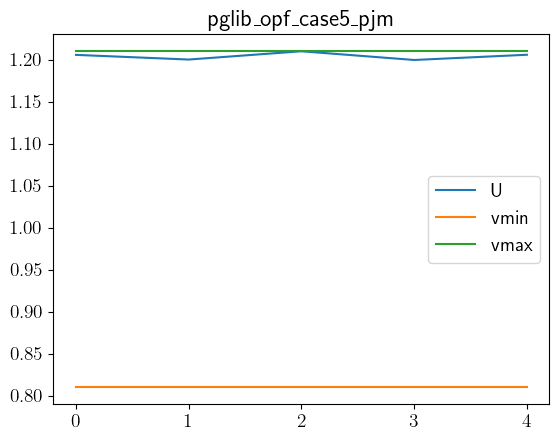

4it [00:23,  6.19s/it]

For case pglib_opf_case500_goc, the most frequent model type is 2.0, presence of any other model is False, coeffs size is 3.


4it [00:32,  8.05s/it]


KeyboardInterrupt: 

In [9]:
for this_case,cn in tqdm(zip(cases,casenames)):
    to_str = lambda x: [str(int(xi)) for xi in x]
    bus_list = to_str(this_case['bus'][:,BUS_I].tolist())
    bus_list_raw = this_case['bus'][:,BUS_I].astype(int)
    bus_basekv = this_case['bus'][:,BASE_KV]
    bus_vmax, bus_vmin = this_case['bus'][:,VMAX], this_case['bus'][:,VMIN]
    bus_pd, bus_qd = this_case['bus'][:,PD], this_case['bus'][:,QD]
    bus_gs, bus_bs = this_case['bus'][:,GS] / this_case['baseMVA'], this_case['bus'][:,BS] / this_case['baseMVA']
    # branches
    BR_ON = this_case['branch'][:,BR_STATUS].astype(bool)
    from_bus = to_str(this_case['branch'][:,F_BUS][BR_ON].tolist())
    to_bus = to_str(this_case['branch'][:,T_BUS][BR_ON].tolist())
    br_r = this_case['branch'][:,BR_R][BR_ON]
    br_x = this_case['branch'][:,BR_X][BR_ON]
    br_b = this_case['branch'][:,BR_B][BR_ON]
    tap = this_case['branch'][:,TAP][BR_ON]
    shift = this_case['branch'][:,TAP][BR_ON]
    angmin,angmax = np.where(np.isclose(this_case['branch'][:,ANGMIN],0),-360*np.ones_like(this_case['branch'][:,ANGMIN]),this_case['branch'][:,ANGMIN]), np.where(np.isclose(this_case['branch'][:,ANGMAX],0),360*np.ones_like(this_case['branch'][:,ANGMAX]),this_case['branch'][:,ANGMAX])
    flow_lim = (this_case['branch'][:,RATE_A][BR_ON])
    branch_list = [(f,t) for f,t in zip(from_bus,to_bus)]
    # generators
    GEN_ON = this_case['gen'][:,GEN_STATUS].astype(bool)
    gen_to_bus = this_case['gen'][:,GEN_BUS][GEN_ON]
    gen_mbase = this_case['gen'][:,MBASE][GEN_ON]
    gen_pmax, gen_pmin = this_case['gen'][:,PMAX][GEN_ON], this_case['gen'][:,PMIN][GEN_ON]
    gen_qmax, gen_qmin = this_case['gen'][:,QMAX][GEN_ON], this_case['gen'][:,QMIN][GEN_ON]
    gencost = this_case['gencost'][:,COST:][GEN_ON]
    # generator cost model
    gmodel = this_case['gencost'][:,MODEL][GEN_ON]
    elements, counts = np.unique(gmodel, return_counts=True)
    most_frequent = elements[counts.argmax()]
    anyother = bool(np.any(elements!=most_frequent))
    print(f"For case {cn}, the most frequent model type is {most_frequent}, presence of any other model is {anyother}, coeffs size is {this_case['gencost'][:,COST:].shape[1]}.")
    # create directed networkx graph
    G = nx.DiGraph()
    for br,r,x,b,t,s,f,amin,amax in zip(branch_list,br_r,br_x,br_b,tap,shift,flow_lim,angmin,angmax):
        # impedances
        t = t if not np.isclose(t,0) else 1.
        yl = 1. / (r + 1j*x)
        tl = t*(math.e**(1j*math.radians(s)))
        yff,ytt = (yl + 1j * (b/2)) * (1 / (tl*tl.conjugate()) ), (yl + 1j * (b/2))
        yft,ytf = - yl / tl.conjugate(), -yl / tl
        # pu for normalizing voltages
        brf,brt = int(br[0]),int(br[1])
        kv_f,kv_t = bus_basekv[np.where(bus_list_raw==brf)], bus_basekv[np.where(bus_list_raw==brt)]
        G.add_edge(u_of_edge=br[0],v_of_edge=br[1],yff=yff,yft=yft,ytf=ytf,ytt=ytt,pu_fac=(kv_f*kv_t).item(),kv_f=kv_f.item(),kv_t=kv_t.item(),kvfsq=(kv_f*kv_f).item(),fmax=f,angmin=amin,angmax=amax,tap=t,shift=s)
    # populate nodes with relevant data
    for bus,kv,pd,qd,vmin,vmax,gs,bs in zip(bus_list_raw,bus_basekv,bus_pd,bus_qd,bus_vmin,bus_vmax,bus_gs,bus_bs):
        busidx = bus_list_raw.tolist().index(bus)
        cgen = np.where(gen_to_bus==bus)[0] if np.where(gen_to_bus==bus)[0].size!=0 else None
        kwlist = {'kvsq':kv*kv,'pd':pd,'qd':qd,'vmin':vmin,'vmax':vmax,'ys':gs+1j*bs,'conn_gen_idx':cgen,'basemva':this_case['baseMVA'],'basegen':gen_mbase,'basekv':bus_basekv[np.where(bus_list_raw==bus)]}
        attr = {str(int(bus)):kwlist}
        nx.set_node_attributes(G, attr)
    # define constants
    n_bus = G.number_of_nodes()
    n_branch = G.number_of_edges()
    n_gen = gen_to_bus.size
    # cp variables
    Pf = cp.Variable(n_branch) # p.u.
    Qf = cp.Variable(n_branch) # p.u.
    Pt = cp.Variable(n_branch) # p.u.
    Qt = cp.Variable(n_branch) # p.u.
    Pgen = cp.Variable(n_gen) # p.u.
    Qgen = cp.Variable(n_gen) # p.u.
    U = cp.Variable(n_bus) # p.u.
    R = cp.Variable(n_branch) # p.u.
    I = cp.Variable(n_branch) # p.u.
    # constraint container
    constr = []
    # indicators
    DISABLE_MODEL = False
    DISABLE_FLOWLIMS = False
    DISABLE_ANG = False
    DISABLE_SOCR = False
    DISABLE_BALANCE = False
    DISABLE_VLIMS = False
    DISABLE_GENLIMS = False
    # branch constraints
    edge_record = []
    for bidx,bdata in enumerate(G.edges(data=True)):
        idx_from,idx_to = bus_list.index(bdata[0]), bus_list.index(bdata[1])
        edge_record.append((bidx,bdata[0],bdata[1]))
        bdata = bdata[2] 
        # branch flow (p.u.)
        if not DISABLE_MODEL:
            constr.append(Pf[bidx] == bdata['yff'].real*U[idx_from] + bdata['yft'].real*R[bidx] + bdata['yft'].imag*I[bidx])
            constr.append(Qf[bidx] == -bdata['yff'].imag*U[idx_from] + bdata['yft'].real*I[bidx] - bdata['yft'].imag*R[bidx])
            constr.append(Pt[bidx] == bdata['ytt'].real*U[idx_to] + bdata['ytf'].real*R[bidx] - bdata['ytf'].imag*I[bidx])
            constr.append(Qt[bidx] == -bdata['ytt'].imag*U[idx_to] - bdata['ytf'].real*I[bidx] - bdata['ytf'].imag*R[bidx])
        # branch flow limits (p.u.)
        if not DISABLE_FLOWLIMS:
            constr.append(cp.norm(cp.hstack([Pf[bidx],Qf[bidx]]),2) <= bdata['fmax'] / this_case['baseMVA'])
            constr.append(cp.norm(cp.hstack([Pt[bidx],Qt[bidx]]),2) <= bdata['fmax'] / this_case['baseMVA'])
        # # branch angle limits (unitless)
        if not DISABLE_ANG:
            constr.append(math.tan(math.radians(bdata['angmin']))*R[bidx] <= I[bidx])
            constr.append(math.tan(math.radians(bdata['angmax']))*R[bidx] >= I[bidx])
        # conic constraints (SOC relaxation) (p.u.)
        if not DISABLE_SOCR:
            constr.append(cp.norm(cp.hstack([U[idx_from]-U[idx_to],2*R[bidx],2*I[bidx]]),2) <= U[idx_from]+U[idx_to])
    # bus constraints
    attr1, attr2 = [], []
    for nidx,ndata in enumerate(G.nodes(data=True)):
        ndata = ndata[1]
        cur_bus = bus_list[nidx]
        in_edges,out_edges = [],[]
        # record in and out edges
        for busname in bus_list:
            for itm in edge_record:
                if itm[1]==cur_bus and itm[2]==busname:
                    out_edges.append(itm[0])
                if itm[2]==cur_bus and itm[1]==busname:
                    in_edges.append(itm[0])
        # nodal balance (standard units)
        Pgen_total = cp.sum([Pgen[gidx] for gidx in ndata['conn_gen_idx']]) if ndata['conn_gen_idx'] is not None else 0
        Qgen_total = cp.sum([Qgen[gidx] for gidx in ndata['conn_gen_idx']]) if ndata['conn_gen_idx'] is not None else 0
        Pd = ndata['pd'] / this_case['baseMVA']
        Qd = ndata['qd'] / this_case['baseMVA']
        P_out = cp.sum([Pt[bidx] for bidx in out_edges]) if out_edges is not [] else 0 # outward real flow
        P_in = cp.sum([Pf[bidx] for bidx in in_edges]) if in_edges is not [] else 0 # inbound real flow
        Q_out = cp.sum([Qt[bidx] for bidx in out_edges]) if out_edges is not [] else 0 # outward imag flow
        Q_in = cp.sum([Qf[bidx] for bidx in in_edges]) if in_edges is not [] else 0 # inbound imag flow
        if not DISABLE_BALANCE:
            constr.append(Pgen_total-Pd
                        -ndata['ys'].real*U[nidx]
                        ==P_in+P_out)
                        #-P_in-P_out==0)
            constr.append(Qgen_total-Qd
                        -ndata['ys'].imag*U[nidx]
                        ==Q_in+Q_out)
                        #-Q_in-Q_out==0)
        else:
            expr1P, expr2P, expr3P, expr4P, expr5P = Pgen_total,-Pd,-ndata['ys'].real*U[nidx],P_in+P_out,ndata['basekv']
            expr1Q, expr2Q, expr3Q, expr4Q, expr5Q = Qgen_total,-Qd,-ndata['ys'].imag*U[nidx],Q_in+Q_out,ndata['basekv']
            attr1.append((expr1P,expr2P,expr3P,expr4P,expr5P))
            attr2.append((expr1Q,expr2Q,expr3Q,expr4Q,expr5Q))
        # voltage limits (no angle limits here since current model only computes angle differences) (p.u.)
        if not DISABLE_VLIMS:
            constr.append(U[nidx]>=np.square(ndata['vmin']))
            constr.append(U[nidx]<=np.square(ndata['vmax']))
    # generators
    if not DISABLE_GENLIMS:
        constr.append(Pgen >= gen_pmin/gen_mbase)
        constr.append(Pgen <= gen_pmax/gen_mbase)
        constr.append(Qgen >= gen_qmin/gen_mbase)
        constr.append(Qgen <= gen_qmax/gen_mbase)
    else:
        # to keep objective bounded
        constr.append(Pgen >= gen_pmin/gen_mbase)
    # define cost function
    quad_fac = np.diag(gencost[:,0])
    lin_fac = gencost[:,1]
    obj = cp.Minimize(cp.quad_form(Pgen,quad_fac)+lin_fac.T@Pgen)
    prob = cp.Problem(obj,constr)
    try:
        prob.solve(solver='MOSEK',verbose=False)
        SOLVER_ERROR = False
    except:
        print("Solver error!")
        SOLVER_ERROR = True
    data = prob.get_problem_data('MOSEK')
    print(f"Problem status is {prob.status}.")
    if prob.status not in ["infeasible", "unbounded"] and SOLVER_ERROR is False:
        # problem is feasible, display relative results
        with open(os.getcwd()+'/'+cn+'_solved.pkl','rb') as file:
            matpower_results = pickle.load(file)
        Prel = np.linalg.norm(matpower_results['gen'][:,PG][GEN_ON] - Pgen.value*gen_mbase) / np.linalg.norm(matpower_results['gen'][:,PG][GEN_ON])
        Qrel = np.linalg.norm(matpower_results['gen'][:,QG][GEN_ON] - ((Qgen.value if Qgen.value is not None else np.zeros_like(gen_mbase))*gen_mbase)) / np.linalg.norm(matpower_results['gen'][:,QG][GEN_ON])
        # appributes
        for id,(a1,b1) in enumerate(zip(attr1,attr2)):
            ga = lambda itm,k: getattr(itm,k,None) if getattr(itm,k,None) is not None else itm
            print(f"Bus {id} P: Gen_total: {ga(a1[0],'value')}, Demand: {ga(a1[1],'value')}, Sh: {ga(a1[2],'value')}, Flows: {ga(a1[3],'value')}, baseKV: {ga(a1[4],'value')}.",flush=True)
            print(f"Bus {id} Q: Gen_total: {ga(b1[0],'value')}, Demand: {ga(b1[1],'value')}, Sh: {ga(b1[2],'value')}, Flows: {ga(b1[3],'value')}, baseKV: {ga(b1[4],'value')}",flush=True)
        # print(f"Optimal: U:{U.value},\npgen:{Pgen.value},\nqgen:{Qgen.value},\nR:{R.value},\nI:{I.value}")
        print(f"Relative ratio of optimal Pg is {Prel} and for optimal Qg is {Qrel}.\n")
        plt.plot(U.value,label='U')
        plt.plot(np.square(bus_vmin),label='vmin')
        plt.plot(np.square(bus_vmax),label="vmax")
        plt.title(cn)
        plt.legend()
        plt.show()
    else:
        # problem is infeasible
        print("Problem infeasible.\n")

In [6]:
G.edges(data=True)

OutEdgeDataView([('2', '212', {'yff': (2.370093105525355-12.142335430445225j), 'yft': (-2.370093105525355+12.155736280445225j), 'ytf': (-2.370093105525355+12.155736280445225j), 'ytt': (2.370093105525355-12.142335430445225j), 'pu_fac': 19044.0, 'kv_f': 138.0, 'kv_t': 138.0, 'kvfsq': 19044.0, 'fmax': 239.94, 'angmin': -30.0, 'angmax': 30.0, 'tap': 1.0, 'shift': 0.0}), ('212', '447', {'yff': (16.640968683995872-94.9989933697152j), 'yft': (-16.640968683995872+95.00141703471519j), 'ytf': (-16.640968683995872+95.00141703471519j), 'ytt': (16.640968683995872-94.9989933697152j), 'pu_fac': 19044.0, 'kv_f': 138.0, 'kv_t': 138.0, 'kvfsq': 19044.0, 'fmax': 258.64, 'angmin': -30.0, 'angmax': 30.0, 'tap': 1.0, 'shift': 0.0}), ('3', '53', {'yff': (5.259081253016218-37.95616931721398j), 'yft': (-5.259081253016218+37.96275071721398j), 'ytf': (-5.259081253016218+37.96275071721398j), 'ytt': (5.259081253016218-37.95616931721398j), 'pu_fac': 19044.0, 'kv_f': 138.0, 'kv_t': 138.0, 'kvfsq': 19044.0, 'fmax': 2

In [8]:
idx_to

499